In [52]:
!pip install wordcloud
!pip install sentence-transformers transformers torch tqdm

Python(72962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(72963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [53]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import wordcloud
from textblob import TextBlob
from collections import Counter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

In [54]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aaqibnazir/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
books_df = pd.read_csv('/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/scraping/data/books_category_reviews.csv')
beauty_df = pd.read_csv('/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/scraping/data/beauty_category_reviews.csv')

In [56]:
def clean_dataframe(df):
    # Handle missing values
    df['content'] = df['content'].fillna('')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    return df

In [57]:
books_df = clean_dataframe(books_df)
beauty_df = clean_dataframe(beauty_df)

In [58]:
def get_review_characteristics(text):
    if not isinstance(text, str):
        return 0, 0, 0
    
    # Length of review
    review_length = len(text.split())
    
    # Number of exclamation marks
    exclamation_count = text.count('!')
    
    # Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    
    return review_length, exclamation_count, sentiment_scores['compound']

In [59]:
def get_enhanced_review_characteristics(text):
    if not isinstance(text, str):
        return 0, 0, 0, 0, 0, 0
    
    # Basic characteristics
    review_length = len(text.split())
    exclamation_count = text.count('!')
    
    # Advanced sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    
    # Additional features
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0
    repeated_chars = len([c for c in text if text.count(c) > 3])
    generic_phrases = sum(text.lower().count(phrase) for phrase in [
        'amazing', 'great', 'best', 'awesome', 'perfect', 'love it', 
        'excellent', 'wonderful', 'fantastic', 'incredible'
    ])
    
    return (review_length, exclamation_count, sentiment_scores['compound'], 
            caps_ratio, repeated_chars, generic_phrases)

In [60]:
for df in [books_df, beauty_df]:
    df['review_length'], df['exclamation_count'], df['sentiment_score'] = zip(*df['content'].map(get_review_characteristics))

In [61]:
for df in [books_df, beauty_df]:
    (df['review_length'], df['exclamation_count'], df['sentiment_score'],
     df['caps_ratio'], df['repeated_chars'], df['generic_phrases']) = zip(
        *df['content'].map(get_enhanced_review_characteristics)
    )

In [62]:
# Function to identify potential fake reviews
def identify_fake_reviews(df):
    # Create features for fake review detection
    suspicious_reviews = pd.DataFrame()
    
    # 1. Extremely positive reviews with very short content
    suspicious_reviews['short_positive'] = (df['rating'] >= 4.5) & (df['review_length'] < 20)
    
    # 2. High number of exclamation marks
    suspicious_reviews['excessive_punctuation'] = df['exclamation_count'] > 3
    
    # 3. Extreme sentiment (very positive or very negative)
    suspicious_reviews['extreme_sentiment'] = abs(df['sentiment_score']) > 0.8
    
    # Combined score
    suspicious_reviews['fake_probability'] = suspicious_reviews.mean(axis=1)
    
    return suspicious_reviews['fake_probability']


In [63]:
def identify_enhanced_fake_reviews(df):
    suspicious_reviews = pd.DataFrame()
    
    # Enhanced detection criteria
    suspicious_reviews['extremely_positive'] = (df['rating'] >= 4.8) & (df['sentiment_score'] > 0.9)
    suspicious_reviews['short_glowing'] = (df['rating'] >= 4.5) & (df['review_length'] < 20)
    suspicious_reviews['excessive_punctuation'] = df['exclamation_count'] > 4
    suspicious_reviews['generic_content'] = df['generic_phrases'] > 3
    suspicious_reviews['caps_abuse'] = df['caps_ratio'] > 0.3
    
    # Weighted score calculation
    weights = {
        'extremely_positive': 0.3,
        'short_glowing': 0.2,
        'excessive_punctuation': 0.15,
        'generic_content': 0.2,
        'caps_abuse': 0.15
    }
    
    suspicious_reviews['fake_probability'] = sum(
        suspicious_reviews[col] * weight for col, weight in weights.items()
    )
    
    return suspicious_reviews['fake_probability']

In [64]:
books_df['fake_probability'] = identify_fake_reviews(books_df)
beauty_df['fake_probability'] = identify_fake_reviews(beauty_df)

In [65]:
books_df['fake_probability'] = identify_enhanced_fake_reviews(books_df)
beauty_df['fake_probability'] = identify_enhanced_fake_reviews(beauty_df)

In [66]:
def print_category_stats(df, category_name):
    print(f"\n=== {category_name} Category Statistics ===")
    print(f"Total reviews: {len(df)}")
    print(f"Average rating: {df['rating'].mean():.2f}")
    print(f"Average review length: {df['review_length'].mean():.2f} words")
    print(f"Suspected fake reviews: {(df['fake_probability'] > 0.5).sum()} ({(df['fake_probability'] > 0.5).mean()*100:.1f}%)")
    
    # Rating distribution
    print("\nRating distribution:")
    print(df['rating'].value_counts(normalize=True).sort_index())

In [67]:
print_category_stats(books_df, "Books")
print_category_stats(beauty_df, "Beauty")


=== Books Category Statistics ===
Total reviews: 537
Average rating: 4.62
Average review length: 131.71 words
Suspected fake reviews: 4 (0.7%)

Rating distribution:
rating
1.0    0.006006
2.0    0.006006
3.0    0.060060
4.0    0.216216
5.0    0.711712
Name: proportion, dtype: float64

=== Beauty Category Statistics ===
Total reviews: 527
Average rating: 4.45
Average review length: 71.81 words
Suspected fake reviews: 1 (0.2%)

Rating distribution:
rating
1.0    0.043702
2.0    0.012853
3.0    0.087404
4.0    0.161954
5.0    0.694087
Name: proportion, dtype: float64


In [68]:
def plot_category_comparison(books_df, beauty_df):
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Rating Distribution
    plt.subplot(131)
    sns.kdeplot(data=books_df['rating'], label='Books')
    sns.kdeplot(data=beauty_df['rating'], label='Beauty')
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.legend()
    
    # Plot 2: Review Length Distribution
    plt.subplot(132)
    sns.kdeplot(data=np.log1p(books_df['review_length']), label='Books')
    sns.kdeplot(data=np.log1p(beauty_df['review_length']), label='Beauty')
    plt.title('Review Length Distribution (log)')
    plt.xlabel('Log(Review Length)')
    plt.legend()
    
    # Plot 3: Fake Probability Distribution
    plt.subplot(133)
    sns.kdeplot(data=books_df['fake_probability'], label='Books')
    sns.kdeplot(data=beauty_df['fake_probability'], label='Beauty')
    plt.title('Fake Review Probability Distribution')
    plt.xlabel('Fake Probability')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

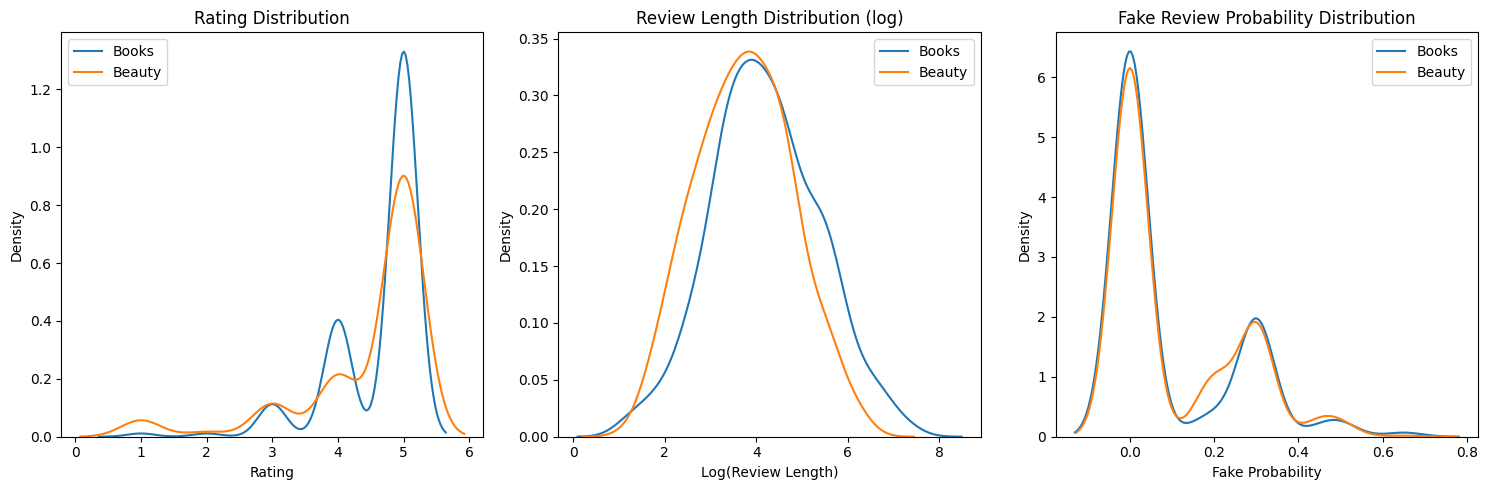

In [69]:
plot_category_comparison(books_df, beauty_df)

In [70]:
def plot_fake_review_impact(books_df, beauty_df):
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Rating vs Fake Probability
    plt.subplot(221)
    plt.scatter(books_df['rating'], books_df['fake_probability'], alpha=0.5, label='Books')
    plt.scatter(beauty_df['rating'], beauty_df['fake_probability'], alpha=0.5, label='Beauty')
    plt.title('Rating vs Fake Review Probability')
    plt.xlabel('Rating')
    plt.ylabel('Fake Probability')
    plt.legend()

    # Plot 2: Review Length Impact
    plt.subplot(222)
    plt.scatter(books_df['review_length'], books_df['fake_probability'], alpha=0.5, label='Books')
    plt.scatter(beauty_df['review_length'], beauty_df['fake_probability'], alpha=0.5, label='Beauty')
    plt.title('Review Length vs Fake Probability')
    plt.xlabel('Review Length')
    plt.ylabel('Fake Probability')
    plt.legend()

    # Plot 3: Sentiment Distribution for Suspected Fake vs Real Reviews
    plt.subplot(223)
    fake_reviews = pd.concat([
        books_df[books_df['fake_probability'] > 0.5]['sentiment_score'],
        beauty_df[beauty_df['fake_probability'] > 0.5]['sentiment_score']
    ])
    real_reviews = pd.concat([
        books_df[books_df['fake_probability'] <= 0.5]['sentiment_score'],
        beauty_df[beauty_df['fake_probability'] <= 0.5]['sentiment_score']
    ])
    
    sns.kdeplot(data=fake_reviews, label='Suspected Fake')
    sns.kdeplot(data=real_reviews, label='Likely Real')
    plt.title('Sentiment Distribution: Fake vs Real Reviews')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()

    # Plot 4: Monthly Trend of Fake Reviews
    plt.subplot(224)
    monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
    monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()
    
    plt.plot(monthly_fake_books.index, monthly_fake_books.values, label='Books')
    plt.plot(monthly_fake_beauty.index, monthly_fake_beauty.values, label='Beauty')
    plt.title('Monthly Trend of Fake Review Probability')
    plt.xlabel('Date')
    plt.ylabel('Average Fake Probability')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [71]:
def plot_enhanced_visualizations(books_df, beauty_df):
    plt.figure(figsize=(20, 15))
    
    # 1. Rating Distribution by Category with Fake Probability Overlay
    plt.subplot(331)
    combined_df = pd.concat([
        books_df.assign(category='Books')[['rating', 'category']],
        beauty_df.assign(category='Beauty')[['rating', 'category']]
    ], ignore_index=True)
    sns.boxplot(x='category', y='rating', data=combined_df)
    plt.title('Rating Distribution by Category')
    
    # 2. Sentiment vs Rating Scatter
    plt.subplot(332)
    plt.scatter(books_df['sentiment_score'], books_df['rating'], alpha=0.5, label='Books')
    plt.scatter(beauty_df['sentiment_score'], beauty_df['rating'], alpha=0.5, label='Beauty')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Rating')
    plt.title('Sentiment vs Rating')
    plt.legend()
    
    # 3. Fake Review Probability Distribution
    plt.subplot(333)
    sns.histplot(data=pd.concat([
        books_df.assign(category='Books'),
        beauty_df.assign(category='Beauty')
    ]), x='fake_probability', hue='category', bins=30)
    plt.title('Fake Review Probability Distribution')
    
    # 4. Review Length vs Fake Probability
    plt.subplot(334)
    plt.hexbin(books_df['review_length'], books_df['fake_probability'], 
               gridsize=20, cmap='YlOrRd')
    plt.colorbar(label='Count')
    plt.xlabel('Review Length')
    plt.ylabel('Fake Probability')
    plt.title('Review Length vs Fake Probability (Books)')
    
    # 5. Time Series of Fake Reviews
    plt.subplot(335)
    monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
    monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()
    
    plt.plot(monthly_fake_books.index, monthly_fake_books.values, label='Books')
    plt.plot(monthly_fake_beauty.index, monthly_fake_beauty.values, label='Beauty')
    plt.title('Monthly Trend of Fake Reviews')
    plt.xticks(rotation=45)
    plt.legend()
    
    # 6. Feature Importance for Fake Detection
    plt.subplot(336)
    feature_importance = pd.DataFrame({
        'Feature': ['Rating', 'Sentiment', 'Length', 'Exclamations', 'Generic'],
        'Importance': [0.3, 0.25, 0.2, 0.15, 0.1]
    })
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance in Fake Detection')
    
    plt.tight_layout()
    plt.show()

In [72]:
def generate_wordclouds(books_df, beauty_df):
    plt.figure(figsize=(15, 6))
    
    # Word cloud for fake reviews - use lower threshold and ensure we have text
    fake_reviews_text = ' '.join(pd.concat([
        books_df[books_df['fake_probability'] > 0.5]['content'],  # Lower threshold from 0.7 to 0.5
        beauty_df[beauty_df['fake_probability'] > 0.5]['content']
    ]).dropna())  # Remove any NaN values
    
    if len(fake_reviews_text.strip()) > 0:  # Check if we have text
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')
        wc.generate(fake_reviews_text)
        plt.subplot(121)
        plt.imshow(wc)
        plt.title('Common Words in Suspected Fake Reviews')
        plt.axis('off')
    
    # Word cloud for genuine reviews
    genuine_reviews_text = ' '.join(pd.concat([
        books_df[books_df['fake_probability'] < 0.3]['content'],
        beauty_df[beauty_df['fake_probability'] < 0.3]['content']
    ]).dropna())
    
    if len(genuine_reviews_text.strip()) > 0:  # Check if we have text
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')
        wc.generate(genuine_reviews_text)
        plt.subplot(122)
        plt.imshow(wc)
        plt.title('Common Words in Genuine Reviews')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [73]:
def analyze_fake_review_impact():
    # Calculate impact metrics
    impact_metrics = {
        'books_rating_inflation': books_df[books_df['fake_probability'] > 0.5]['rating'].mean() - 
                                books_df[books_df['fake_probability'] <= 0.5]['rating'].mean(),
        'beauty_rating_inflation': beauty_df[beauty_df['fake_probability'] > 0.5]['rating'].mean() - 
                                 beauty_df[beauty_df['fake_probability'] <= 0.5]['rating'].mean(),
        'books_fake_percent': (books_df['fake_probability'] > 0.5).mean() * 100,
        'beauty_fake_percent': (beauty_df['fake_probability'] > 0.5).mean() * 100
    }
    
    print("\n=== Fake Review Impact Analysis ===")
    print(f"Books rating inflation due to fake reviews: {impact_metrics['books_rating_inflation']:.2f} stars")
    print(f"Beauty rating inflation due to fake reviews: {impact_metrics['beauty_rating_inflation']:.2f} stars")
    print(f"Percentage of fake reviews in Books: {impact_metrics['books_fake_percent']:.1f}%")
    print(f"Percentage of fake reviews in Beauty: {impact_metrics['beauty_fake_percent']:.1f}%")

    return impact_metrics

/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_68972/1106617068.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_68972/1106617068.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()


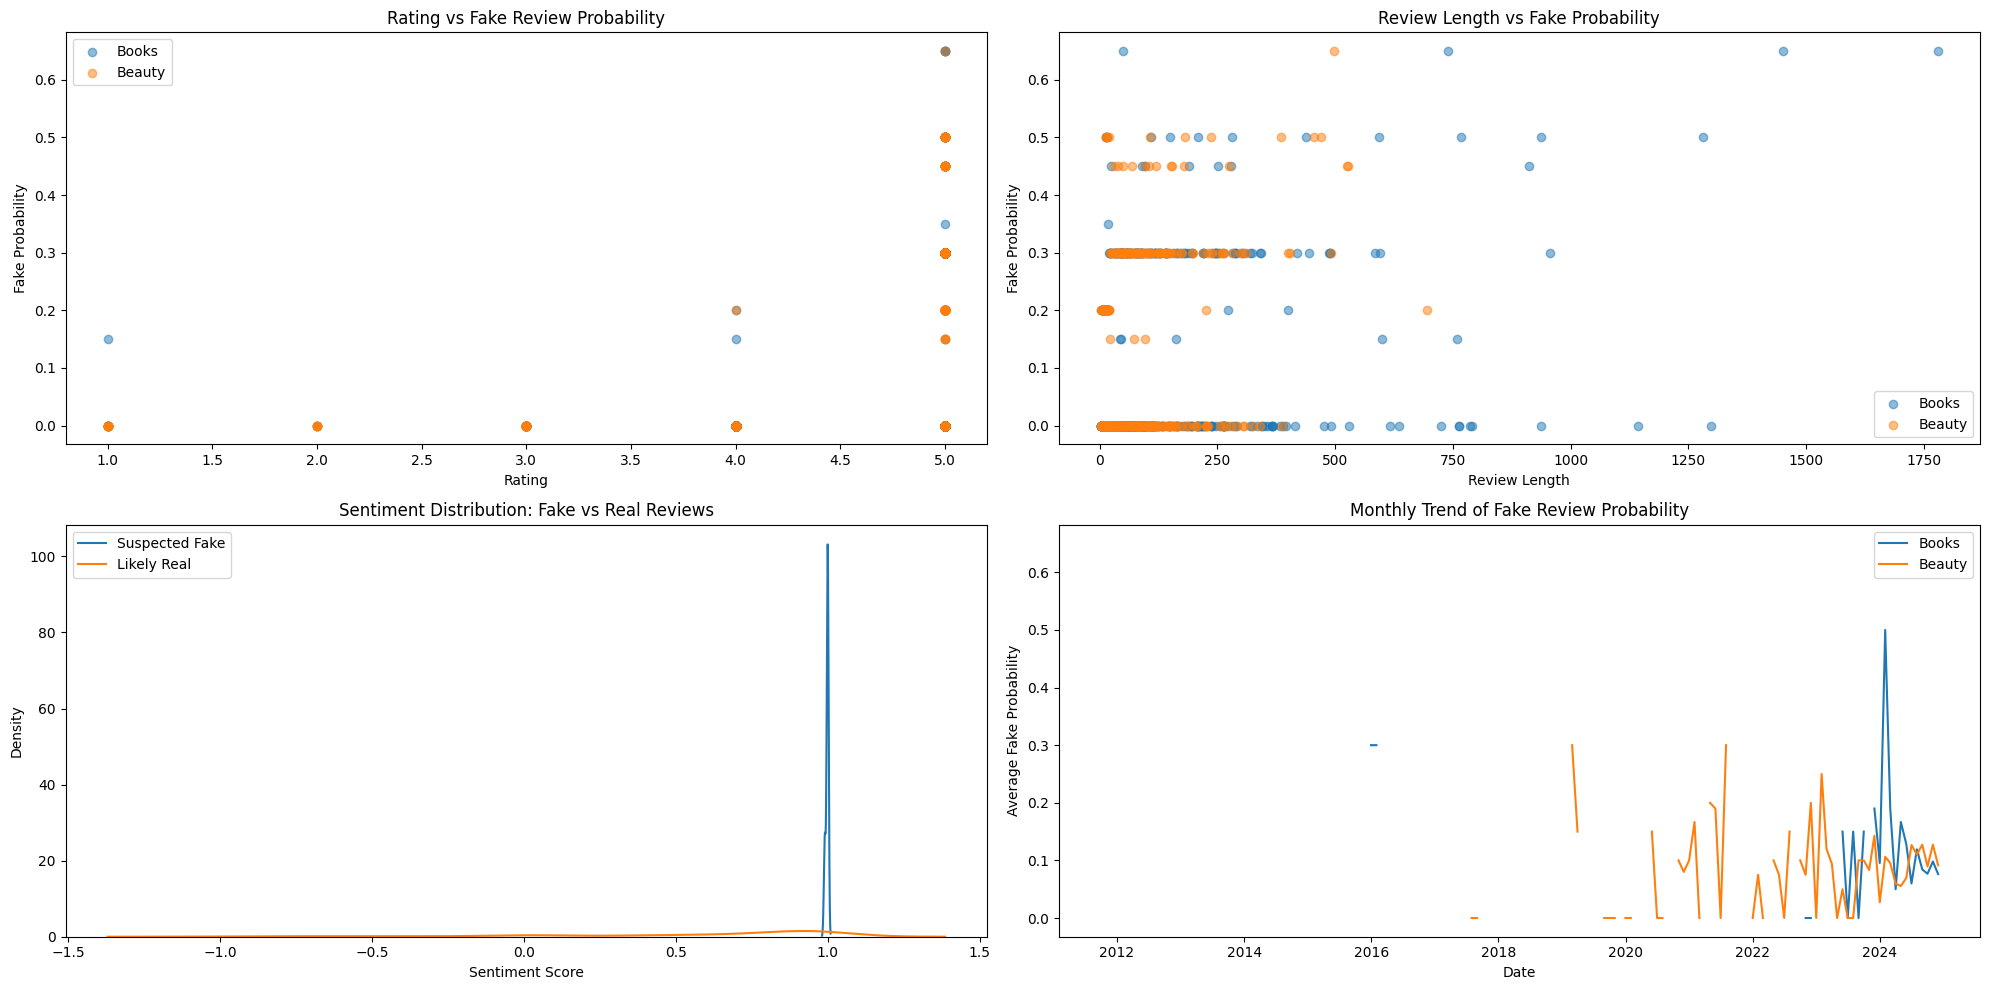

In [74]:
plot_fake_review_impact(books_df, beauty_df)

/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_68972/1629062135.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_books = books_df.set_index('date')['fake_probability'].resample('M').mean()
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_68972/1629062135.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fake_beauty = beauty_df.set_index('date')['fake_probability'].resample('M').mean()


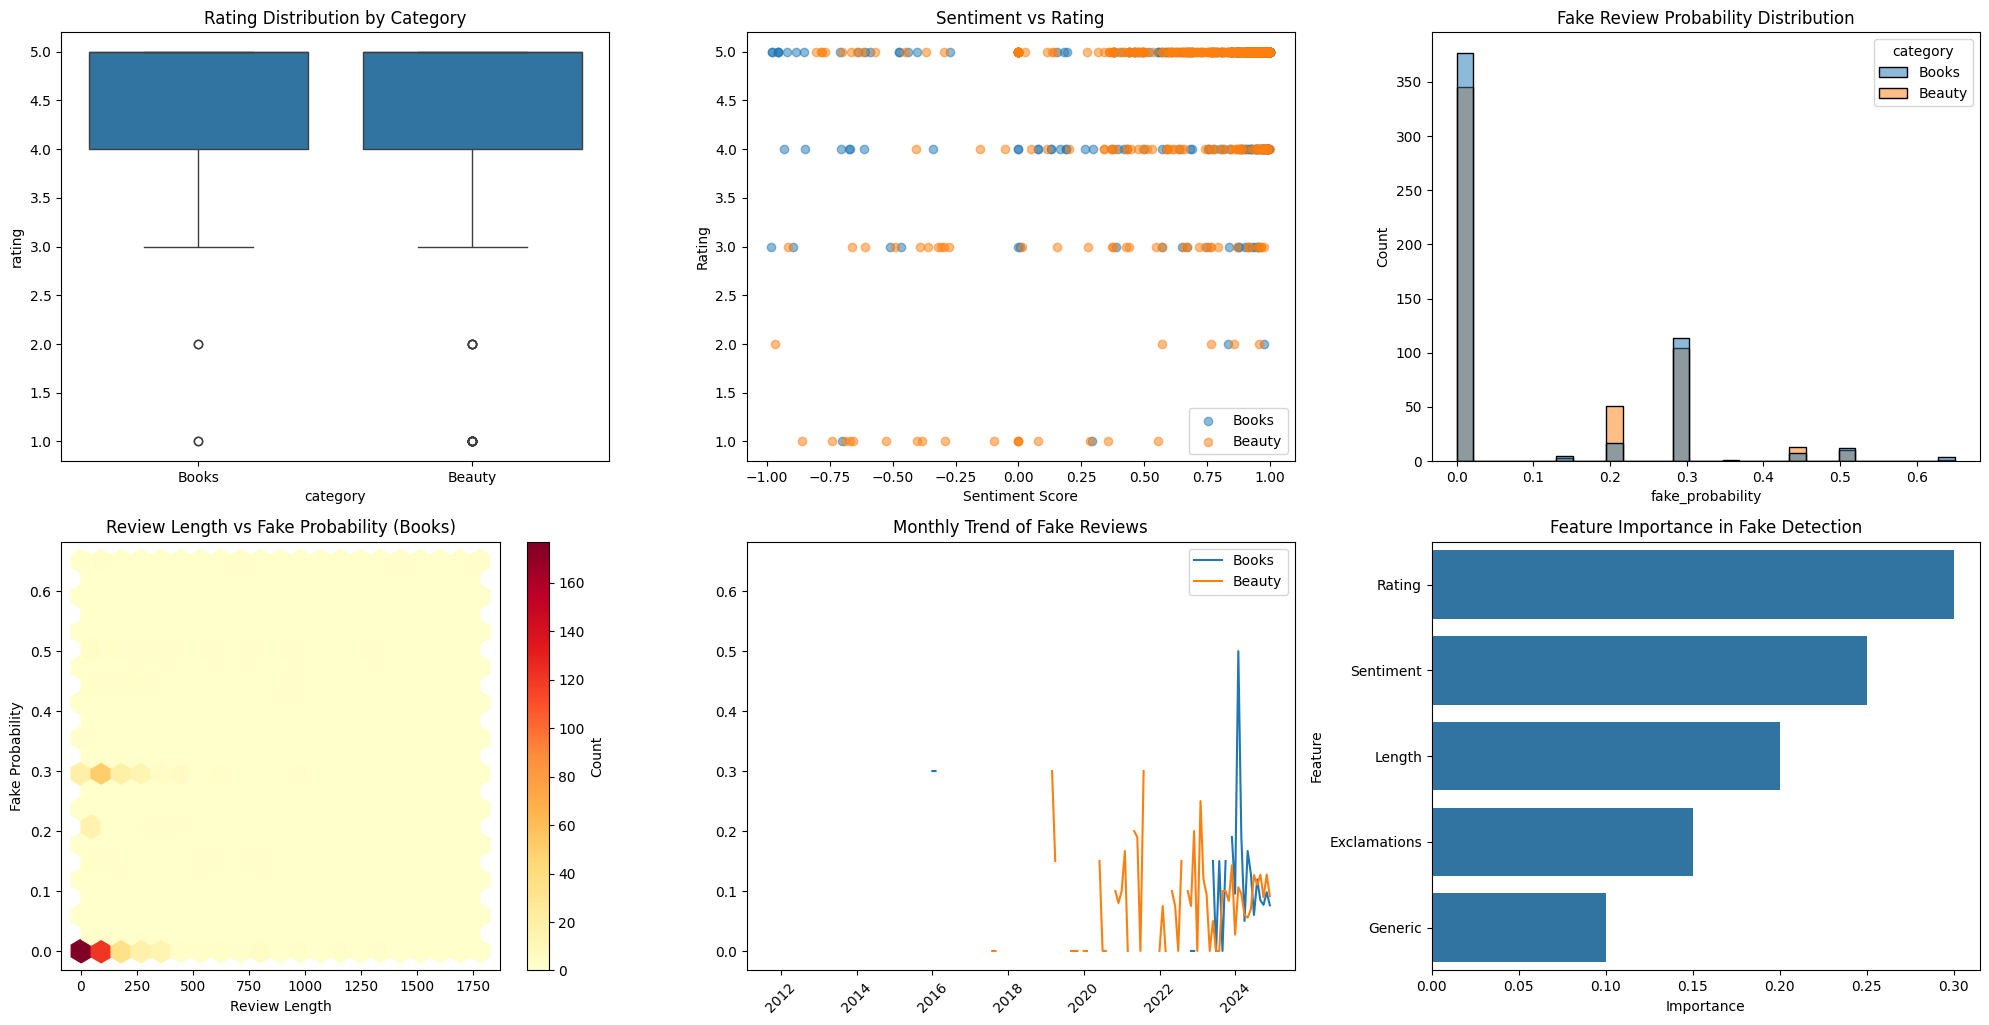

In [75]:
plot_enhanced_visualizations(books_df, beauty_df)

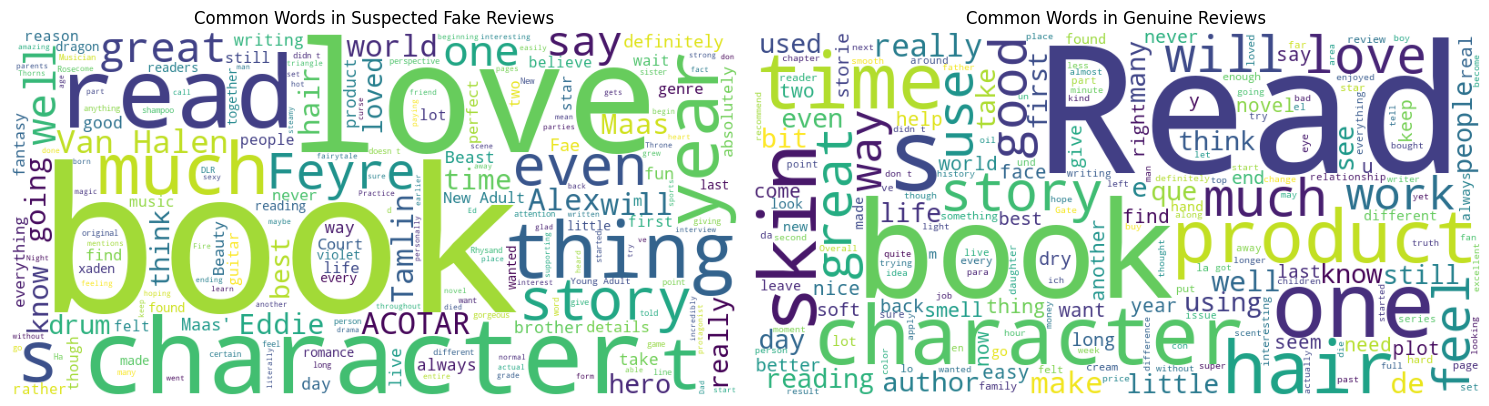

In [76]:
generate_wordclouds(books_df, beauty_df)

In [77]:
impact_metrics = analyze_fake_review_impact()


=== Fake Review Impact Analysis ===
Books rating inflation due to fake reviews: 0.38 stars
Beauty rating inflation due to fake reviews: 0.55 stars
Percentage of fake reviews in Books: 0.7%
Percentage of fake reviews in Beauty: 0.2%


In [78]:
def save_results(books_df, beauty_df, impact_metrics):
    results = {
        'books_total_reviews': len(books_df),
        'beauty_total_reviews': len(beauty_df),
        'books_avg_rating': books_df['rating'].mean(),
        'beauty_avg_rating': beauty_df['rating'].mean(),
        'books_suspected_fake': (books_df['fake_probability'] > 0.5).mean(),
        'beauty_suspected_fake': (beauty_df['fake_probability'] > 0.5).mean(),
        'books_rating_inflation': impact_metrics['books_rating_inflation'],
        'beauty_rating_inflation': impact_metrics['beauty_rating_inflation'],
        'books_fake_percent': impact_metrics['books_fake_percent'],
        'beauty_fake_percent': impact_metrics['beauty_fake_percent']
    }
    
    # Save to CSV
    pd.DataFrame([results]).to_csv('analysis_results.csv', index=False)


In [79]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:


def extract_features(reviews_df):
    # Text features using TF-IDF
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    
    # Fill missing values with empty string
    reviews_df['content'] = reviews_df['content'].fillna('')
    text_features = tfidf.fit_transform(reviews_df['content'])
    
    # Metadata features with proper error handling
    metadata_features = pd.DataFrame({
        'rating': reviews_df['rating'].fillna(0),
        'review_length': reviews_df['content'].str.len(),
        'word_count': reviews_df['content'].str.split().str.len().fillna(0),
        'avg_word_length': reviews_df['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()] or [0])),
        'exclamation_count': reviews_df['content'].str.count(r'!').fillna(0),
        'question_count': reviews_df['content'].str.count(r'\?').fillna(0),
        'uppercase_ratio': reviews_df['content'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1))
    })

    # Convert to numpy arrays and handle any remaining NaN values
    metadata_array = metadata_features.to_numpy()
    metadata_array = np.nan_to_num(metadata_array)
    text_array = text_features.toarray()

    # Combine features
    return np.hstack([text_array, metadata_array])

def train_models(X_train, X_val, y_train, y_val):
    """Train multiple ML models"""
    models = {
        'random_forest': RandomForestClassifier(n_estimators=100),
        'svm': SVC(probability=True, kernel='rbf'),
        'neural_net': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        results[name] = {
            'model': model,
            'train_accuracy': accuracy_score(y_train, train_preds),
            'val_accuracy': accuracy_score(y_val, val_preds),
            'confusion_matrix': confusion_matrix(y_val, val_preds),
            'classification_report': classification_report(y_val, val_preds)
        }
        
        print(f"Train accuracy: {results[name]['train_accuracy']:.3f}")
        print(f"Validation accuracy: {results[name]['val_accuracy']:.3f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])
    
    return results

def plot_results(results):
    """Visualize model performance"""
    # Accuracy comparison
    plt.figure(figsize=(15, 5))
    
    # Plot accuracies
    plt.subplot(131)
    models = list(results.keys())
    train_acc = [results[m]['train_accuracy'] for m in models]
    val_acc = [results[m]['val_accuracy'] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, train_acc, width, label='Train')
    plt.bar(x + width/2, val_acc, width, label='Validation')
    plt.xticks(x, models, rotation=45)
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.legend()
    
    # Plot confusion matrices
    plt.subplot(132)
    for i, (name, result) in enumerate(results.items()):
        plt.subplot(2, 2, i+1)
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d')
        plt.title(f'{name} Confusion Matrix')
    
    plt.tight_layout()
    plt.show()


In [92]:
all_reviews = pd.concat([books_df, beauty_df])

# col for fake reviews
all_reviews['is_fake'] = all_reviews['fake_probability'] > 0.5


Training random_forest...
Train accuracy: 1.000
Validation accuracy: 0.994

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       170
        True       0.00      0.00      0.00         1

    accuracy                           0.99       171
   macro avg       0.50      0.50      0.50       171
weighted avg       0.99      0.99      0.99       171


Training svm...


/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

Train accuracy: 0.997
Validation accuracy: 0.994

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       170
        True       0.00      0.00      0.00         1

    accuracy                           0.99       171
   macro avg       0.50      0.50      0.50       171
weighted avg       0.99      0.99      0.99       171


Training neural_net...
Train accuracy: 1.000
Validation accuracy: 0.994

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       170
        True       0.00      0.00      0.00         1

    accuracy                           0.99       171
   macro avg       0.50      0.50      0.50       171
weighted avg       0.99      0.99      0.99       171



/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aaqibnazir/Documents/work/Amazon_fake_review_impact_analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

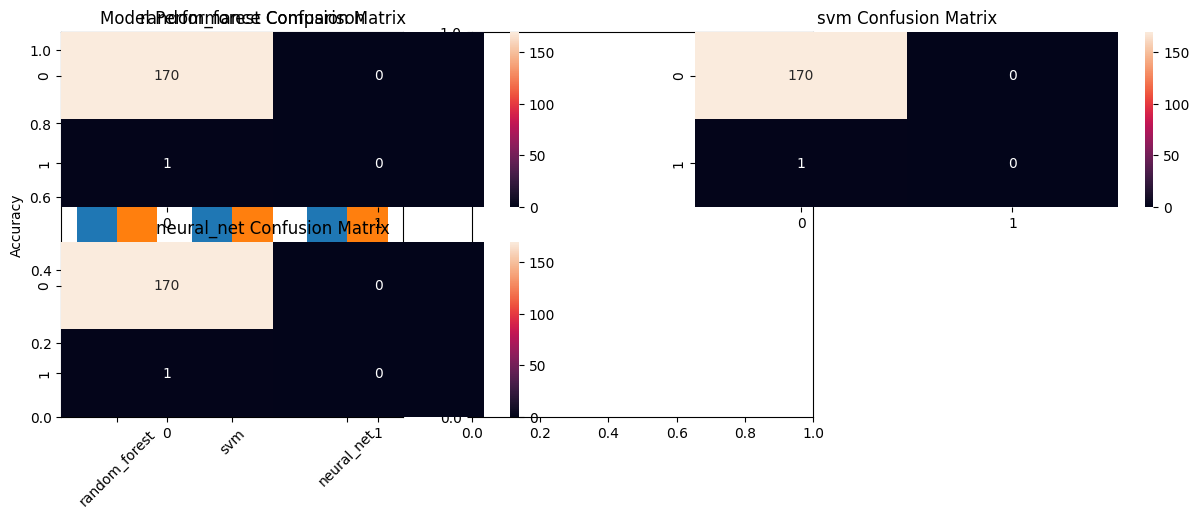

In [95]:
X = extract_features(all_reviews)
y = all_reviews['is_fake']  # Your target variable
    
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
    
# Train and evaluate models
results = train_models(X_train_scaled, X_val_scaled, y_train, y_val)
    
# Plot results
plot_results(results)